In [8]:
# Create a smal function to fetch the data
import os
import urllib
import tarfile

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing_kw")
HOUSING_URL = DOWNLOAD_ROOT+"datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL,
                      housing_path = HOUSING_PATH):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [9]:
#load data into pandas
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

housing_data = load_housing_data()

In [10]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [11]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [14]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [15]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


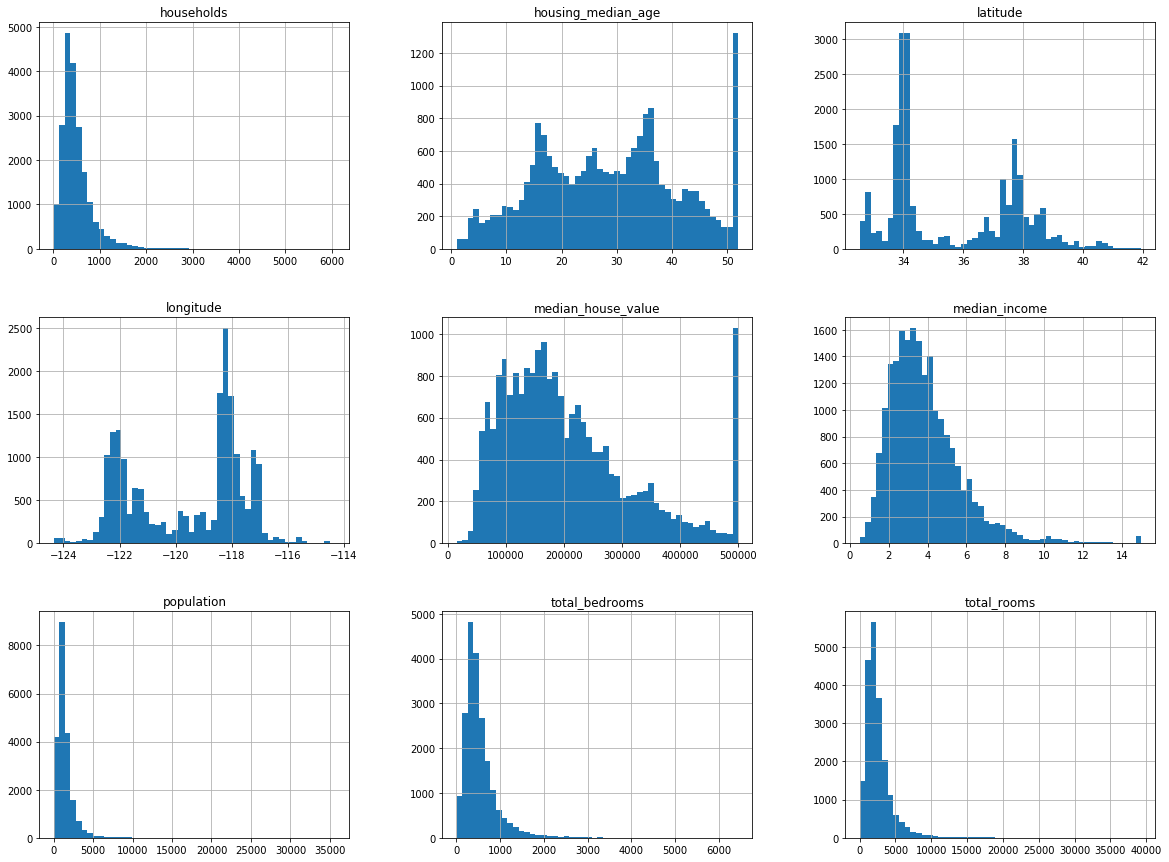

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
housing_data.hist(bins=50,figsize=(20,15))
plt.show()

In [18]:
import numpy as np
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]


In [39]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier))& 0xffffffff < test_ratio*2**32

def split_train_test(data,id_column,test_ratio):
    ids = data[id_column]
    indices = ids.apply(lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~indices],data.loc[indices]

#use longitude and latitude as unqiue identifier
housing_with_id = housing_data.reset_index()
housing_with_id['id'] = housing_data['longitude']*1000+housing_data['latitude']
train_set,test_set = split_train_test(housing_with_id,'id',0.2)

In [41]:
#using sklearn to split data
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_data,test_size=0.2,random_state=42)

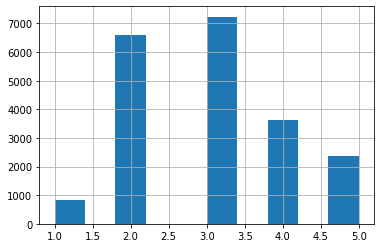

In [42]:
#Sample from strata
housing_data['income_cat']= pd.cut(housing_data['median_income'],
                                  bins=[0.,1.5,3.,4.5,6,np.inf],
                                  labels=[1,2,3,4,5])
housing_data['income_cat'].hist()

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_indices, test_indices in split.split(housing_data,housing_data['income_cat']):
    train_set = housing_data.iloc[train_indices]
    test_set = housing_data.iloc[test_indices]


In [57]:
for set_ in [train_set, test_set]:
    set_.drop('income_cat',axis=1,inplace=True)

C:\Users\kawang\Desktop\Advisory Project\JE Testing\Forecast_Python_Package_V3\jeForecastVenv\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


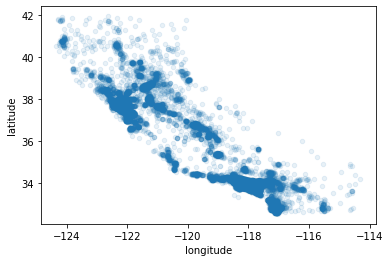

In [59]:
housing = train_set.copy()
#geo plot
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

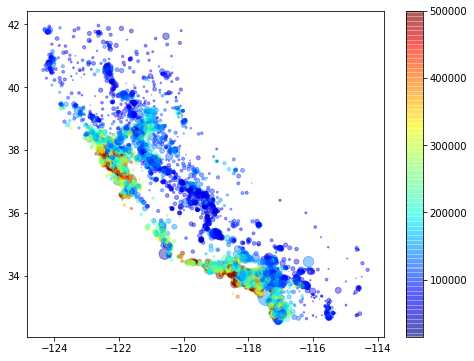

In [72]:
fig,ax1 = plt.subplots(1,figsize=(8,6))
chart1 = ax1.scatter(housing['longitude'],housing['latitude'], alpha=0.4,
           s=housing['population']/100,
           label='population',
           c=housing['median_house_value'],
           cmap=plt.get_cmap('jet'))
fig.colorbar(chart1, ax=ax1)

In [75]:
#get correlation
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011F5CECCCC8>,
      dtype=object)

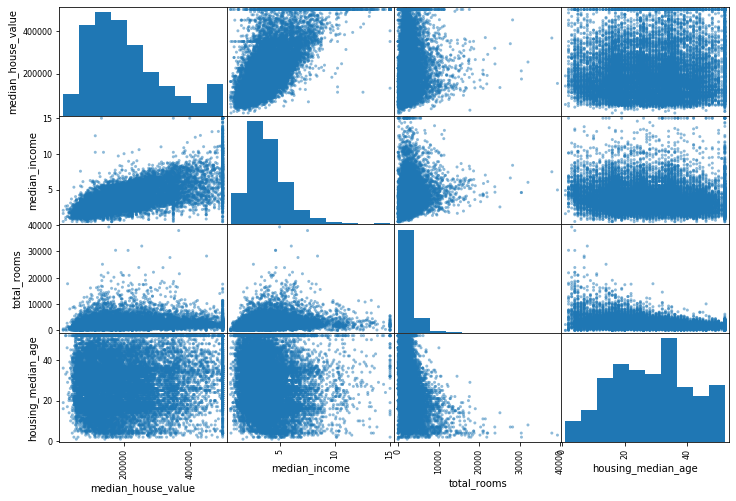

In [76]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value','median_income',
             'total_rooms','housing_median_age']
scatter_matrix(housing[attributes],figsize=(12,8))

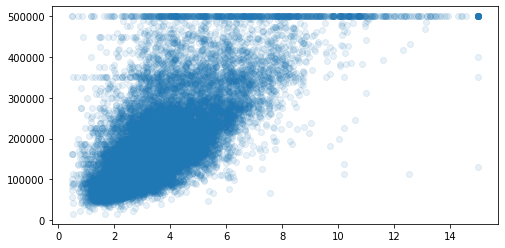

In [77]:
fig,ax2 = plt.subplots(1,figsize=(8,4))
ax2.scatter(x=housing['median_income'],
           y=housing['median_house_value'],alpha=0.1)

In [79]:
housing['rooms_per_household']=housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household']=housing['population']/housing['households']

In [81]:
housing_corr_matrix = housing.corr()
housing_corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [95]:
housing = train_set.drop('median_house_value',axis=1)
housing_label = train_set['median_house_value'].copy()

In [99]:
#use sklearn to clean missing data
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num= housing.drop('ocean_proximity',axis=1)
housing_num = housing.select_dtypes(include=[np.number]).copy()

imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median(axis=0).values)

X=imputer.transform(housing_num)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [103]:
#processing categorical fields
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

ordinal_encoder = OrdinalEncoder()
one_hot_encoder = OneHotEncoder()

housing_cat = housing[['ocean_proximity']].copy()

housing_cat_code = ordinal_encoder.fit_transform(housing_cat)
housing_cat_one_hot = one_hot_encoder.fit_transform(housing_cat)

In [114]:
#customize function
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix,bedrooms_ix,population_ix,households_ix=3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_rooms=True):
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        room_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_households = X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_rooms:
            bedrooms_per_rooms = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,room_per_household,
                        population_per_households,
                        bedrooms_per_rooms]
        else:
            return np.c_[X,room_per_household,
                        population_per_households]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_rooms=False)
housing_extra_attribs = attr_adder.transform(housing.values)
            

In [128]:
#Building Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_columns = list(housing_num)
char_columns = ['ocean_proximity']

num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('combine_attr', CombinedAttributesAdder()),
    ('scaler',StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num_pipe',num_pipeline,num_columns),
    ('char_pipe',OneHotEncoder(),char_columns)
])

housing_processed = full_pipeline.fit_transform(housing)

In [133]:
#build a simple linear model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_model = LinearRegression()

lr_model.fit(housing_processed,housing_label)
lr_predictions = lr_model.predict(housing_processed)

lr_rmse = np.sqrt(mean_squared_error(housing_label,lr_predictions))
print(lr_rmse)

68628.19819848923


In [135]:
#build a decision tree model
from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor()
reg_tree.fit(housing_processed,housing_label)
reg_tree_predictions = reg_tree.predict(housing_processed)

reg_tree_rmse = np.sqrt(mean_squared_error(housing_label,reg_tree_predictions))
print(reg_tree_rmse)

0.0


In [136]:
#n_fold cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(reg_tree, housing_processed,housing_label,
                        scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores:',scores)
    print('mean:', scores.mean())
    print('std:', scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69310.1758121  68120.4299348  72557.56175908 68880.44190538
 70656.69459621 75038.08551699 70834.85039644 72600.3338393
 77269.0818024  70442.80264344]
mean: 71571.04582061339
std: 2709.7825184814046


In [138]:
lr_cv_scores = cross_val_score(lr_model,
                              housing_processed,housing_label,
                              scoring='neg_mean_squared_error',cv=10)
lr_cv_rmse = np.sqrt(-lr_cv_scores)

display_scores(lr_cv_rmse)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean: 69052.46136345083
std: 2731.6740017983425


In [146]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor()

rfr_model.fit(housing_processed, housing_label)
rfr_model_predictions = rfr_model.predict(housing_processed)
rfr_rmse = np.sqrt(mean_squared_error(housing_label,rfr_model_predictions))
print(rfr_rmse)

rfr_cv_score = cross_val_score(rfr_model,
                              housing_processed, housing_label,
                              scoring='neg_mean_squared_error',cv=10)

rfr_cv_rmse = np.sqrt(-rfr_cv_score)

display_scores(rfr_cv_rmse)

C:\Users\kawang\Desktop\Advisory Project\JE Testing\Forecast_Python_Package_V3\jeForecastVenv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22483.71851271702
Scores: [51287.39534514 49781.41661662 52885.33904812 55368.95532717
 52045.07661587 55913.79959695 52770.93469782 50398.75667207
 55645.63691027 53034.53864363]
mean: 52913.184947365546
std: 2050.9425575928763


In [147]:
#Save model
import joblib

joblib.dump(rfr_model,'my_model.pkl')
rfr_model = joblib.load('my_model.pkl')

In [151]:
#Grid Search for the Best Hyper Parameters
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],
    'max_features':[2,4,6,8]},
    {'bootstrap':[False],
    'n_estimators':[3,10],
    'max_features':[2,3,4]}
]

rfr_model = RandomForestRegressor()

grid_search = GridSearchCV(rfr_model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(housing_processed,housing_label)

print(grid_search.best_params_)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score),params)

{'max_features': 6, 'n_estimators': 30}
63756.76546883802 {'max_features': 2, 'n_estimators': 3}
56075.61528636977 {'max_features': 2, 'n_estimators': 10}
53023.887964415924 {'max_features': 2, 'n_estimators': 30}
59208.81637767217 {'max_features': 4, 'n_estimators': 3}
53058.62821910412 {'max_features': 4, 'n_estimators': 10}
50576.1392052624 {'max_features': 4, 'n_estimators': 30}
59050.9523799126 {'max_features': 6, 'n_estimators': 3}
52245.586131592325 {'max_features': 6, 'n_estimators': 10}
49904.920111985295 {'max_features': 6, 'n_estimators': 30}
58443.81812393453 {'max_features': 8, 'n_estimators': 3}
52175.74819022477 {'max_features': 8, 'n_estimators': 10}
50113.23585171082 {'max_features': 8, 'n_estimators': 30}
61601.377484877616 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54428.8528897424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59750.398514069195 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52916.924571979835 {'bootstrap': F

In [155]:
#random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
    'max_features': randint(low=1, high=8),
    'n_estimators': randint(low=1,high=400)
}

rfr_model = RandomForestRegressor()

rnd_search = RandomizedSearchCV(rfr_model, param_grid, cv=5,
                           n_iter = 10, scoring='neg_mean_squared_error',random_state=42)

rnd_search.fit(housing_processed,housing_label)

print(rnd_search.best_params_)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 7, 'n_estimators': 349}
49089.82631454742 {'max_features': 7, 'n_estimators': 349}
49300.260268541926 {'max_features': 7, 'n_estimators': 107}
50562.596863874496 {'max_features': 5, 'n_estimators': 21}
49188.87479399037 {'max_features': 7, 'n_estimators': 122}
50249.53978795172 {'max_features': 3, 'n_estimators': 215}
50557.07055292739 {'max_features': 3, 'n_estimators': 88}
49292.189143526484 {'max_features': 5, 'n_estimators': 100}
50332.072231774895 {'max_features': 3, 'n_estimators': 150}
49138.5471115703 {'max_features': 5, 'n_estimators': 258}
49457.210195651496 {'max_features': 4, 'n_estimators': 294}


In [161]:
#feature importance
feature_importance = rnd_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_household','population_per_household','bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['char_pipe']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_columns+extra_attribs+cat_one_hot_attribs
feature_importance_df = pd.DataFrame({'features': attributes,
                                     'importances':feature_importance}).sort_values('importances',
                                                                                    ascending=False)
feature_importance_df

,features,importances
7,median_income,0.340903
12,INLAND,0.161859
9,population_per_household,0.110867
10,bedrooms_per_room,0.073970
0,longitude,0.071652
1,latitude,0.064967
8,rooms_per_household,0.055404
2,housing_median_age,0.042694
3,total_rooms,0.016366
5,population,0.016102


In [162]:
#run final model on the test dataset
final_model = rnd_search.best_estimator_

housing_test = test_set.drop('median_house_value',axis=1)
housing_test_label = test_set[['median_house_value']].copy()

housing_test_processed = full_pipeline.transform(housing_test)

test_predictions = final_model.predict(housing_test_processed)
test_rmse = np.sqrt(mean_squared_error(housing_test_label,test_predictions))
print(test_rmse)

46683.44858990268


In [165]:
test_predictions.shape

(4128,)

In [170]:
housing_test_label.values.reshape(-1,1).shape

(4128, 1)

In [171]:
#compute 95% confidence interval
from scipy import stats

confidence = 0.95
squared_errors = (test_predictions.reshape(-1,1) - housing_test_label.values) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([[44717.04026945],
       [48570.3104173 ]])

## Exercises 

In [182]:
from sklearn.svm import SVR

svr_model = SVR()
param_grid = [{'kernel': ['linear'],
              'C': [1.,10.],
              'degree':[1,2,3]},
             {'kernel': ['rbf'],
              'C': [1.,10.],
              'degree':[1,2,3],
              'gamma':[0.01,0.1]}
             ]

grid_search_svr = GridSearchCV(svr_model, param_grid,
                              cv=5, scoring='neg_mean_squared_error',return_train_score=True)

grid_search_svr.fit(housing_processed, housing_label)
print(grid_search_svr.best_params_)
cvrs = grid_search_svr.cv_results_
for mse, params in zip(cvrs['mean_test_score'],cvrs['params']):
    print(np.sqrt(-mse), params)

{'C': 10.0, 'degree': 1, 'kernel': 'linear'}
112571.79521013204 {'C': 1.0, 'degree': 1, 'kernel': 'linear'}
112571.79521013204 {'C': 1.0, 'degree': 2, 'kernel': 'linear'}
112571.79521013204 {'C': 1.0, 'degree': 3, 'kernel': 'linear'}
84654.0893002138 {'C': 10.0, 'degree': 1, 'kernel': 'linear'}
84654.0893002138 {'C': 10.0, 'degree': 2, 'kernel': 'linear'}
84654.0893002138 {'C': 10.0, 'degree': 3, 'kernel': 'linear'}
118810.1205690511 {'C': 1.0, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
118637.95452846108 {'C': 1.0, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
118810.1205690511 {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
118637.95452846108 {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
118810.1205690511 {'C': 1.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf'}
118637.95452846108 {'C': 1.0, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
117855.86860610843 {'C': 10.0, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
116179.73058899572 {'C': 10.0, 'degree': 1, 'gamma': 0.1, 'k

In [183]:
from scipy.stats import expon, reciprocal

svr_model = SVR()
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

rnd_search_svr = RandomizedSearchCV(svr_model, param_distribs,
                              cv=5, scoring='neg_mean_squared_error',n_iter=10,
                                   random_state=42)

rnd_search_svr.fit(housing_processed, housing_label)
print(rnd_search_svr.best_params_)
cvrs = rnd_search_svr.cv_results_
for mse, params in zip(cvrs['mean_test_score'],cvrs['params']):
    print(np.sqrt(-mse), params)

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}
70487.73975752539 {'C': 629.782329591372, 'gamma': 3.010121430917521, 'kernel': 'linear'}
65151.98496543675 {'C': 26290.206464300216, 'gamma': 0.9084469696321253, 'kernel': 'rbf'}
100293.08900577638 {'C': 84.14107900575871, 'gamma': 0.059838768608680676, 'kernel': 'rbf'}
70574.11375177321 {'C': 432.37884813148855, 'gamma': 0.15416196746656105, 'kernel': 'linear'}
118838.76739914888 {'C': 24.17508294611391, 'gamma': 3.503557475158312, 'kernel': 'rbf'}
70029.23360936904 {'C': 113564.03940586245, 'gamma': 0.0007790692366582295, 'kernel': 'rbf'}
107662.52814484686 {'C': 108.30488238805073, 'gamma': 0.3627537294604771, 'kernel': 'rbf'}
77562.95173075002 {'C': 21.344953672647435, 'gamma': 0.023332523598323388, 'kernel': 'linear'}
62578.76510141139 {'C': 5603.270317432516, 'gamma': 0.15023452872733867, 'kernel': 'rbf'}
54767.99053704408 {'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}


In [220]:
def indices_of_top_k(arr,k):
    sorted_indices = np.argsort(arr)[-k:]
    return np.sort(sorted_indices)

class feature_selection(BaseEstimator,TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances,self.k)
        return self
    
    def transform(self,X):
        return X[:,self.feature_indices_]
        
feature_importances = rnd_search.best_estimator_.feature_importances_

preparation_select_pipeline = Pipeline([
    ('preparation',full_pipeline),
    ('selection',feature_selection(feature_importances=feature_importances,
                                  k=5))
])

housing_processed_selected = preparation_select_pipeline.fit_transform(housing)

In [226]:
k = 5
preparation_select_prediction_pipeline = Pipeline([
    ('preparation',full_pipeline),
    ('selection',feature_selection(feature_importances,k)),
    ('prediction', SVR(**rnd_search_svr.best_params_))
])

preparation_select_prediction_pipeline.fit(housing,housing_label)
new_train_predictions = preparation_select_prediction_pipeline.predict(housing)

In [232]:
#use grid search to identify preparation options
param_space = {'preparation__num_pipe__impute__strategy':['mean','median','most_frequent'],
              'selection__k': list(range(1, len(feature_importances) + 1))}
                                                      
preparation_search = GridSearchCV(preparation_select_prediction_pipeline,param_space,
                                  scoring='neg_mean_squared_error',
                                  cv=5, return_train_score=True
            )

preparation_search.fit(housing,housing_label)

preparation_search.best_params_

{'preparation__num_pipe__impute__strategy': 'most_frequent',
 'selection__k': 15}